# setup

In [1]:
!pip install category-encoders

In [34]:
!pip install catboost

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import TargetEncoder

from catboost import CatBoostRegressor

import os
import matplotlib.pyplot as plt
import seaborn as sns

my_seed = 59

# data

In [22]:
csvs_folder = '/kaggle/input/cian-big-three/cian_data'
csvs_paths = [os.path.join(csvs_folder, csv) for csv in os.listdir(csvs_folder)]
ds_full = pd.read_csv(csvs_paths[0], delimiter=';')

for csv in csvs_paths[1:]:
    ds_part = pd.read_csv(csv, delimiter=';')
    ds_full = pd.concat([ds_full, ds_part], axis=0, ignore_index=True)

print(len(ds_full))

17107


In [23]:
ds_full.reset_index()
ds_full.head()

,author,author_type,url,location,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,price,district,street,house_number,underground,residential_complex
0,Форум-групп,developer,https://ekb.cian.ru/sale/flat/306151208/,Екатеринбург,sale,flat,25,29,5,128.0,34024538.0,Центр,Центральный жилрайон,NaN,Площадь 1905 года,Форма ЖК
1,РЕПУТАЦИЯ,real_estate_agent,https://ekb.cian.ru/sale/flat/304987190/,Екатеринбург,sale,flat,2,10,5,164.0,13300000.0,Орджоникидзевский,переулок Замятина,28,Проспект Космонавтов,NaN
2,PR FLAT,real_estate_agent,https://ekb.cian.ru/sale/flat/315286042/,Екатеринбург,sale,flat,10,10,5,132.6,16100790.0,Центр,Шейнкмана,110,Геологическая,NaN
3,TEN девелопмент,developer,https://ekb.cian.ru/sale/flat/313517303/,Екатеринбург,sale,flat,11,16,5,159.7,69135000.0,Центр,Февральской Революции,21,Динамо,19/05
4,Кулиговская и Партнёры,real_estate_agent,https://ekb.cian.ru/sale/flat/314597466/,Екатеринбург,sale,flat,21,23,5,162.4,64960000.0,Октябрьский,Тверитина,46,Геологическая,NaN


# preprocessing

Основные идеи:
1) избавиться от выбросов;
2) target encoding для категориальных признаков;
3) скалирование числовых признаков.

In [24]:
ds_full = ds_full.dropna(axis=0, subset=['price'])
# "location" is important if data contains different cities
redundant_columns = ['author', 'url', 'deal_type', 'accommodation_type']
ds_full = ds_full.drop(redundant_columns, axis=1)
print(len(ds_full))
print(ds_full.describe())

16575
              floor  floors_count   rooms_count  total_meters         price
count  16575.000000  16575.000000  16575.000000  16575.000000  1.657500e+04
mean       7.955053     15.892549      2.624314     87.304992  4.916935e+07
std        7.915672     10.653911      1.310068     60.377137  1.178342e+08
min       -1.000000     -1.000000     -1.000000     10.760000  4.000000e+05
25%        3.000000      8.000000      2.000000     48.000000  9.833106e+06
50%        5.000000     13.000000      3.000000     68.000000  1.520000e+07
75%       11.000000     23.000000      4.000000    104.100000  3.616831e+07
max       82.000000     95.000000      5.000000    979.500000  2.862950e+09


Максимальная и минимальная цены на квартиру:
2862950000.0 400000.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


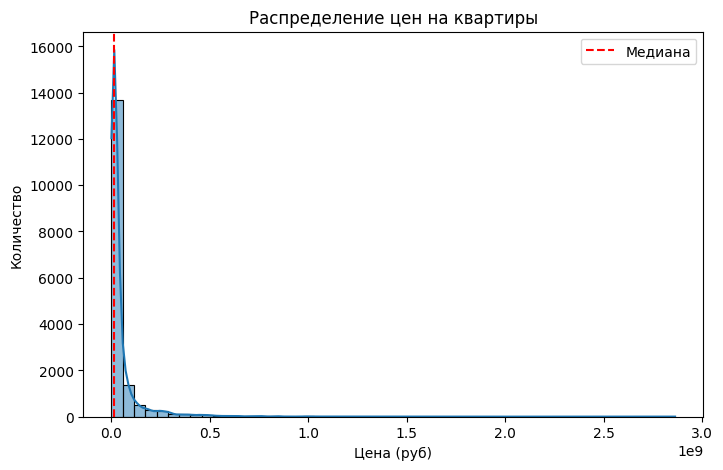

In [25]:
# anomalies in price

print('Максимальная и минимальная цены на квартиру:')
print(max(ds_full['price']), min(ds_full['price']))

plt.figure(figsize=(8, 5))
sns.histplot(ds_full['price'], bins=50, kde=True)
plt.title('Распределение цен на квартиры')
plt.xlabel('Цена (руб)')
plt.ylabel('Количество')
plt.axvline(x=ds_full['price'].median(), color='r', linestyle='--', label='Медиана')
plt.legend()
plt.show();

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


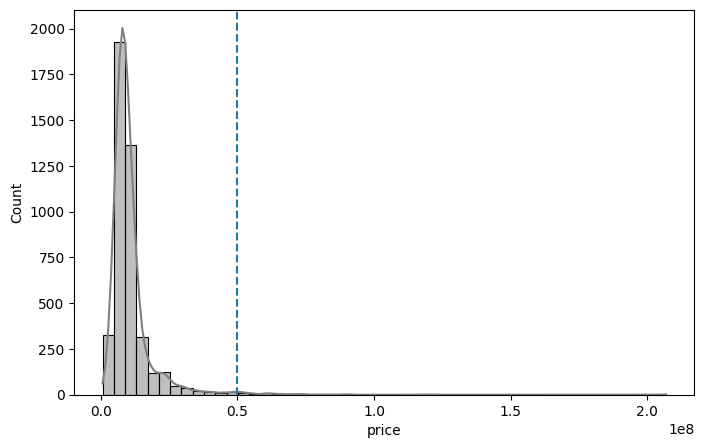

In [26]:
ds_full = ds_full[(ds_full['price'] > 5e5) & (ds_full['price'] < 5e8)]

plt.figure(figsize=(8, 5))
sns.histplot(ds_full[ds_full['location'] == 'Екатеринбург']['price'], bins=50, kde=True, color='gray')
plt.axvline(x=ds_full[ds_full['location'] == 'Екатеринбург']['price'].quantile(0.99), linestyle='dashed')
plt.show();

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


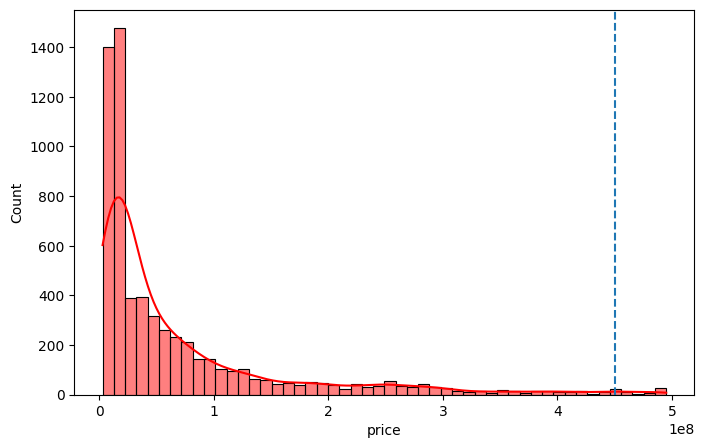

In [27]:
plt.figure(figsize=(8, 5))
sns.histplot(ds_full[ds_full['location'] == 'Москва']['price'], bins=50, kde=True, color='red')
plt.axvline(x=ds_full[ds_full['location'] == 'Москва']['price'].quantile(0.99), linestyle='dashed')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


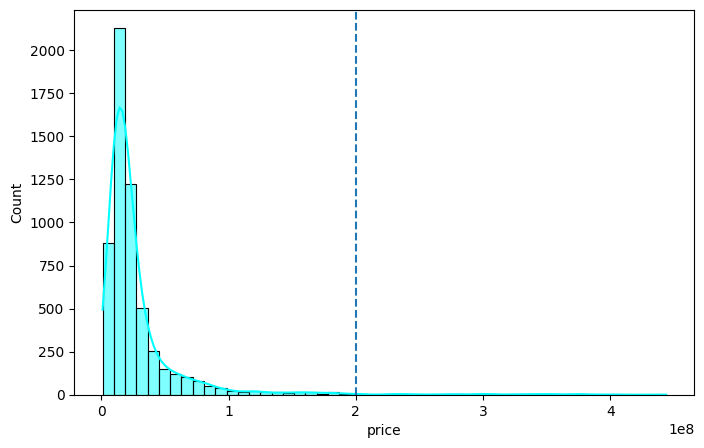

In [28]:
plt.figure(figsize=(8, 5))
sns.histplot(ds_full[ds_full['location'] == 'Санкт-Петербург']['price'], bins=50, kde=True, color='cyan')
plt.axvline(x=ds_full[ds_full['location'] == 'Санкт-Петербург']['price'].quantile(0.99), linestyle='dashed')
plt.show()

In [29]:
# для каждого города выкидываем то, что ниже 0.05 и выше 0.95 перцентилей

for city in ds_full['location'].unique():
    low = ds_full[ds_full['location'] == city]['price'].quantile(0.05)
    high = ds_full[ds_full['location'] == city]['price'].quantile(0.95)
    anomalies = ds_full[(ds_full['location'] == city) & ((ds_full['price'] < low) | (ds_full['price'] > high))].index
    print(f'{len(anomalies)} anomalies for {city} city')
    ds_full.drop(anomalies, inplace=True)

print(len(ds_full))

437 anomalies for Екатеринбург city
576 anomalies for Санкт-Петербург city
628 anomalies for Москва city
14741


In [30]:
# drop rooms_count == -1
ds_full = ds_full[ds_full['rooms_count'] > 0]
print(len(ds_full))

14732


In [11]:
# фича квадратных метров для EDA
# ds_full['price_per_m2'] = ds_full['price'] / ds_full['total_meters']

In [12]:
# fix NaN in cat. features
object_cols = [col for col in ds_full.columns if ds_full[col].dtype == "object"]
for col in object_cols:
    ds_full[col] = ds_full[col].fillna('unknown')
    ds_full[col] = ds_full[col].str.strip().str.lower()

In [13]:
X, y = ds_full.drop(['price'], axis=1), ds_full['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=my_seed)
print(len(X_train), len(X_test), len(y_train), len(y_test))

12852 3213 12852 3213


In [14]:
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# high cardinality in some columns
sorted(d.items(), key=lambda x: x[1])

[('location', 3),
 ('author_type', 7),
 ('district', 181),
 ('underground', 368),
 ('residential_complex', 1270),
 ('house_number', 1368),
 ('street', 1891)]

In [15]:
# target encoding for high cardinality
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 20]
print(low_cardinality_cols)
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))
print(high_cardinality_cols)

encoder = TargetEncoder(cols=high_cardinality_cols, smoothing=10.0)

X_train_encoded = encoder.fit_transform(X_train[high_cardinality_cols], y_train)
X_test_encoded = encoder.transform(X_test[high_cardinality_cols])

X_train = pd.concat([X_train.drop(high_cardinality_cols, axis=1), X_train_encoded], axis=1)
X_test = pd.concat([X_test.drop(high_cardinality_cols, axis=1), X_test_encoded], axis=1)

['author_type', 'location']
['residential_complex', 'district', 'street', 'house_number', 'underground']


In [16]:
# scaling all numeric cols, including target encoded

numeric_cols = [col for col in X_train.columns if (X_train[col].dtype in ['int64', 'float64', 'int32', 'float32'])]
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [17]:
# ohe encoding for low cardinality

ohe_encoding = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
for col in low_cardinality_cols:
    ohe_cats_array = ohe_encoding.fit_transform(X_train[[col]])
    ohe_cats_df = pd.DataFrame(ohe_cats_array, 
                               columns=[f"{col}_{cat}" for cat in ohe_encoding.categories_[0]],
                               index=X_train.index)
    X_train = pd.concat([X_train, ohe_cats_df], axis=1).drop([col], axis=1)

    ohe_test_cats_array = ohe_encoding.transform(X_test[[col]])
    ohe_test_cats_df = pd.DataFrame(ohe_test_cats_array, 
                                    columns=[f"{col}_{cat}" for cat in ohe_encoding.categories_[0]],
                                    index=X_test.index)
    
    X_test = pd.concat([X_test, ohe_test_cats_df], axis=1).drop([col], axis=1)

X_train.head()

,floor,floors_count,rooms_count,total_meters,residential_complex,district,street,house_number,underground,author_type_developer,author_type_homeowner,author_type_official_representative,author_type_real_estate_agent,author_type_realtor,author_type_representative_developer,author_type_unknown,location_екатеринбург,location_москва,location_санкт-петербург
13431,-0.744559,-0.753411,-1.260215,-0.680794,-0.193242,-0.619809,-0.538593,-0.892946,-0.671365,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14618,-0.248083,-0.846083,1.083337,0.152795,-0.017989,0.534957,0.032709,0.211381,2.512690,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6723,-0.372202,0.822014,-0.479031,-0.451367,-0.683260,-0.425759,-0.646835,-0.555536,-0.384917,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7829,-0.744559,-0.197379,1.864521,2.598622,1.476997,2.528967,1.273738,0.720998,1.991951,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
11755,-0.620440,-0.382723,0.302153,0.543067,0.482906,0.534957,0.711659,0.387370,-0.389865,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:
# old frequency encoding
# maybe normalize in .value_counts()?..
# for col in high_cardinality_cols:
#     freq_map = X_train[col].value_counts(normalize=True).to_dict()
    
#     X_train[col+'_freqs'] = X_train[col].map(freq_map)
#     X_train = X_train.drop(col, axis=1)

#     X_test[col+'_freqs'] = X_test[col].map(freq_map)
#     X_test = X_test.drop(col, axis=1)

In [44]:
X_train.to_pickle('x_train.pkl') 
y_train.to_pickle('y_train.pkl') 
X_test.to_pickle('x_test.pkl') 
y_test.to_pickle('y_test.pkl') 

In [20]:
print(X_train.columns)
X_train.head()

Index(['floor', 'floors_count', 'rooms_count', 'total_meters',
       'residential_complex', 'district', 'street', 'house_number',
       'underground', 'author_type_developer', 'author_type_homeowner',
       'author_type_official_representative', 'author_type_real_estate_agent',
       'author_type_realtor', 'author_type_representative_developer',
       'author_type_unknown', 'location_екатеринбург', 'location_москва',
       'location_санкт-петербург'],
      dtype='object')


,floor,floors_count,rooms_count,total_meters,residential_complex,district,street,house_number,underground,author_type_developer,author_type_homeowner,author_type_official_representative,author_type_real_estate_agent,author_type_realtor,author_type_representative_developer,author_type_unknown,location_екатеринбург,location_москва,location_санкт-петербург
13431,-0.744559,-0.753411,-1.260215,-0.680794,-0.193242,-0.619809,-0.538593,-0.892946,-0.671365,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14618,-0.248083,-0.846083,1.083337,0.152795,-0.017989,0.534957,0.032709,0.211381,2.512690,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6723,-0.372202,0.822014,-0.479031,-0.451367,-0.683260,-0.425759,-0.646835,-0.555536,-0.384917,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7829,-0.744559,-0.197379,1.864521,2.598622,1.476997,2.528967,1.273738,0.720998,1.991951,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
11755,-0.620440,-0.382723,0.302153,0.543067,0.482906,0.534957,0.711659,0.387370,-0.389865,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


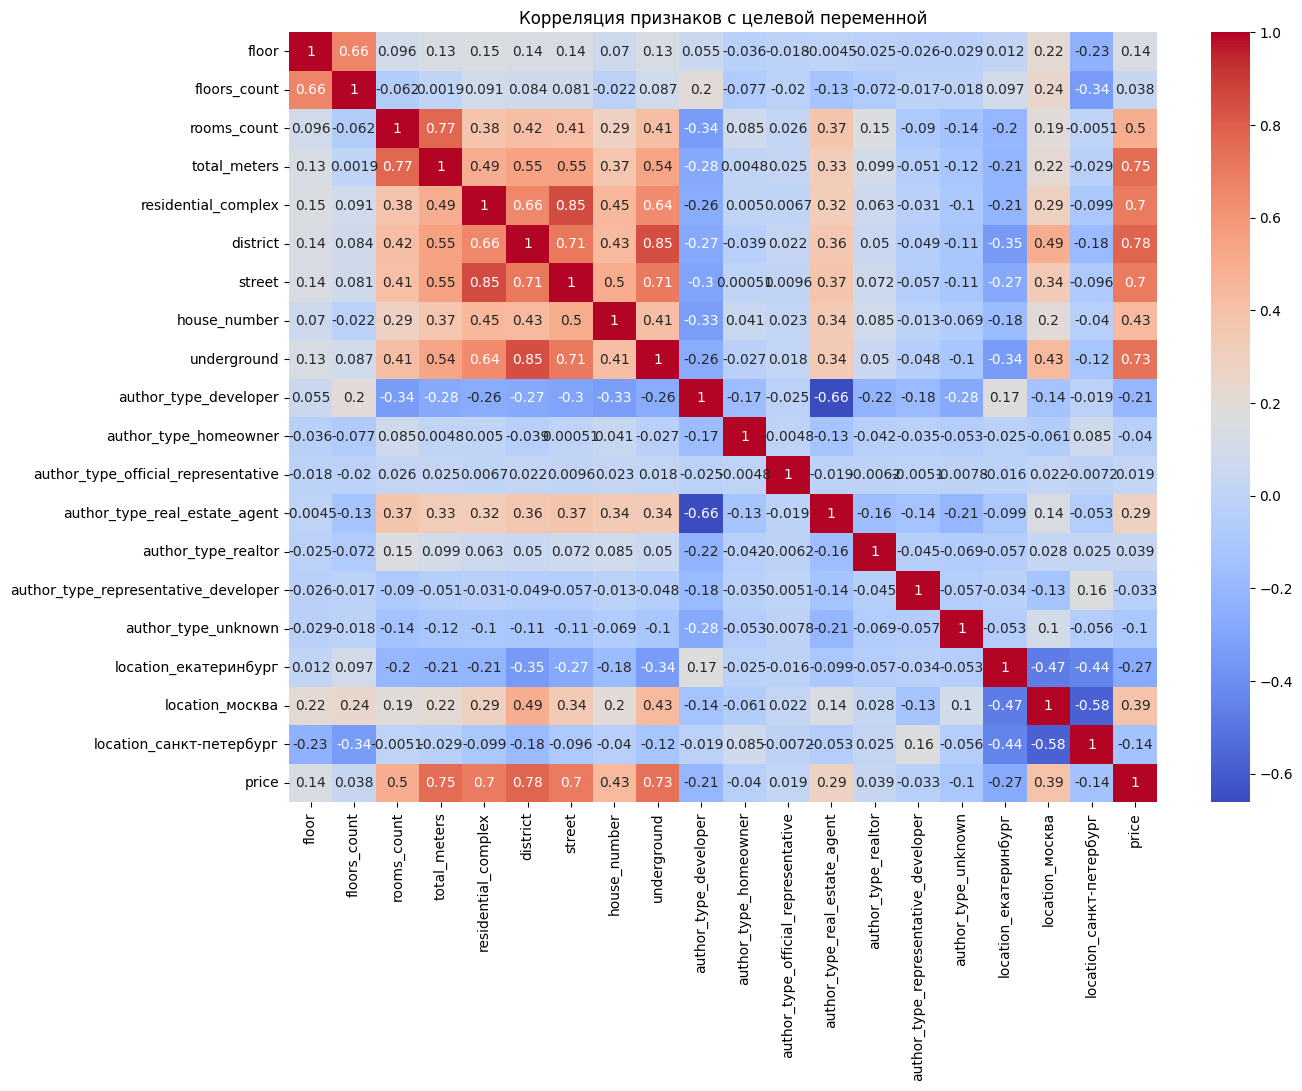

In [33]:
corr_matrix = X_train.join(y_train).corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляция признаков с целевой переменной')
plt.show()

# catboost

In [36]:
model = CatBoostRegressor()
model.fit(X_train, y_train, verbose=100)

Learning rate set to 0.061291
0:	learn: 58941060.6462052	total: 58ms	remaining: 57.9s
100:	learn: 16299890.2950866	total: 349ms	remaining: 3.11s
200:	learn: 14052192.0936770	total: 635ms	remaining: 2.52s
300:	learn: 12554538.2071048	total: 925ms	remaining: 2.15s
400:	learn: 11566126.8444858	total: 1.21s	remaining: 1.81s
500:	learn: 10807752.5936333	total: 1.5s	remaining: 1.49s
600:	learn: 10192558.2012664	total: 1.79s	remaining: 1.19s
700:	learn: 9575716.7903749	total: 2.08s	remaining: 887ms
800:	learn: 9087144.6141671	total: 2.37s	remaining: 588ms
900:	learn: 8599662.6588319	total: 2.65s	remaining: 292ms
999:	learn: 8190475.0470855	total: 2.94s	remaining: 0us


In [41]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Root Mean Squared Error (RMSE):", mse**0.5)
print("R² Score:", r2)

Root Mean Squared Error (RMSE): 14979783.783872828
R² Score: 0.933295241647871


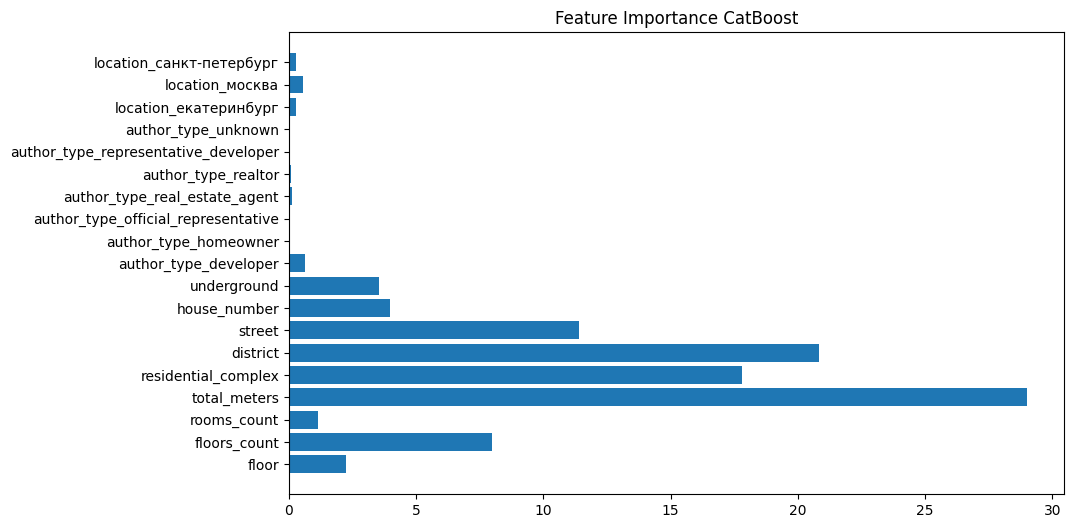

In [43]:
feature_importance = model.get_feature_importance()
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importance)
plt.title('Feature Importance CatBoost')
plt.show()

Следующий очевидный шаг на данный момент - поделить датасет на три отдельных города, так как таргет-закодированные фичи тут имеют очень большой вес, при этом цена очень сильно зависит от города, и у OHE признаков локации, кажется, не получается разделить города между собой

Текущие метрики:
1) tabpfn

   Root Mean Squared Error (RMSE): 18183348.75

   R² Score: 0.9017

3) catboost

   Root Mean Squared Error (RMSE): 14979783.78

   R² Score: 0.9333